[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/tmp/ipykernel_63721/584832904.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
/tmp/ipykernel_63721/584832904.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)


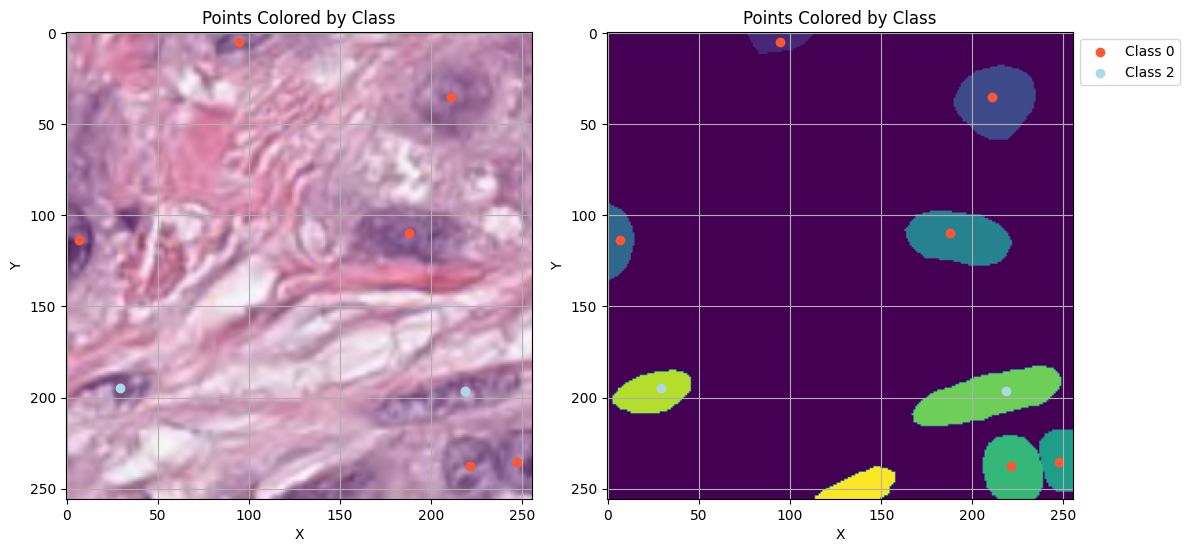

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image

# 生成固定的数字-颜色映射
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
colors = ['#FF5733', '#FFA500', '#ADD8E6', '#800080', '#FFFFFF']

cmap = ListedColormap(colors)

# 读取npy文件
data = np.load("/data/hotaru/my_projects/PromptNucSeg/segmentor/prompts/pannuke123/2_0.npy")
mask_data = np.load("/data/hotaru/my_projects/PromptNucSeg/segmentor/datasets/pannuke/Masks/2_0.npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象

# 获取mask数据
mask = mask_data['inst_map']
print(mask_data["type_map"])

# 提取坐标和类别信息
points = data[:, :2]
labels = data[:, 2]

# 打开PNG图像
image_path = "/data/hotaru/my_projects/PromptNucSeg/segmentor/datasets/pannuke/Images/2_0.png"
image = Image.open(image_path)


# 创建绘图对象和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 在第一个子图中绘制原始图像和点
axes[0].imshow(image)
for label in np.unique(labels):
    idx = labels == label
    axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_title("Points Colored by Class")
axes[0].grid(True)

# 在第二个子图中绘制mask和点
axes[1].imshow(mask, cmap='viridis')
for label in np.unique(labels):
    idx = labels == label
    axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_title("Points Colored by Class")
axes[1].grid(True)
# 在每个子图的外部显示图例
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
# 调整布局
plt.tight_layout()

# 保存结果图像
plt.savefig("result_combined.png")
plt.show()

# 错误统计

## image-class 


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.io import loadmat
import cv2

# 生成固定的数字-颜色映射
colors = ['#FF5733',  '#ADD8E6', '#FFD700','#800080', '#FFFFFF',]
colors_mask = ['#FFFFFF', '#FF1F00',  '#4080FF', '#FFFF00','#2D0040', '#999999']
 # 用于绘制 mask 图，颜色保持一致
cmap = ListedColormap(colors)
cmap_mask = ListedColormap(colors_mask)

#return inst_map,type_map,points,points_labels
def load_dataset(dataset,file_name,file_path):
    if dataset == 'pannuke':
        point_data = np.load(file_path+"/"+file_name+".npy")
        mask_data = np.load("/data/hotaru/projects/PNS_tmp/segmentor/datasets/pannuke/Masks/"+file_name+".npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = mask_data['type_map']
    elif dataset == 'cpm17':
        point_data = np.load("/data/hotaru/projects/PNS_tmp/segmentor/prompts/cpm17_300/"+file_name+".npy")
        mask_data = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/"+file_name+".mat")  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = np.ones_like(inst_map)
    else:
        print("暂不支持其他数据集")
        return
    # 提取坐标和类别信息
    points = point_data[:, :2]
    points_labels = point_data[:, 2]
    return inst_map,type_map,points,points_labels

#return [num_gt_instances,num_points,true_counts,m_back_count,m_front_count,l_single_count,l_multi_count,cls_false_count,all_false_num],temp_inst_map,semantic_liantong_map
def count_false_points(inst_map,type_map,points,points_labels):
    #初始化所需变量
    temp_inst_map = inst_map.copy()
    temp_inst_map = temp_inst_map.astype(np.int8)  # 转换为 CV_8U
    _ , binary_semantic_map = cv2.connectedComponents(temp_inst_map,connectivity=4) 
    binary_semantic_map = binary_semantic_map.astype(np.int8)

    num_gt_instances = 0 # 0. gt总数
    num_points = 0       # 1. points总数
    true_counts = 0      # 2. 正确总数
    m_back_count = 0     # 3. 背景多检
    m_front_count = 0    # 4. 前景多检
    l_single_count = 0   # 5. 单独漏检 需要改
    l_multi_count = 0    # 6. 粘连漏检 需要改
    cls_false_count = 0  # 7. 类别错误
    all_false_num = 0    # 8. 错误总数


    num_gt_instances = len(np.unique(inst_map)) - 1  # 0. 减去背景标签
    num_points = len(points)                          # 1.
    '''
        开始计算
        * 2. 正确总数：前景非零&非-1&类别正确/没有类别,更新temp_inst_map&semantic_binary_map
        * 4. 前景多检：temp_inst_map = -1
        * 5. 单独漏检：剩余语义图连通图数目
        * 6. 粘连漏检：剩余实例图数目 - 剩余语义图数目
        * 7. 类别错误：前景非零&非-1&类别错误,更新temp_inst_map&semantic_binary_map
    '''
    
    for point , point_label in zip(points,points_labels):
        x,y = int(point[1]),int(point[0])
        label = point_label
        point_is_correct = False # flag
        if temp_inst_map[x, y] != 0 and  temp_inst_map[x, y] != -1 and label == type_map[x,y]-1 :  # 2.
            true_counts += 1
            point_is_correct = True        
            # 删掉已经定位的inst
            liantong_num, liantong_map = cv2.connectedComponents(binary_semantic_map,connectivity=4) 
            temp_inst_id = temp_inst_map[x, y]  
            temp_liantong_id = liantong_map[x,y]
            for i in range(temp_inst_map.shape[0]):  
                for j in range(temp_inst_map.shape[1]):  
                    if temp_inst_map[i, j] == temp_inst_id:  
                        temp_inst_map[i, j] = -1  
                    if liantong_map[i,j] == temp_liantong_id:
                        binary_semantic_map[i, j] = 0

        if point_is_correct == False and inst_map[x, y] == 0:   #3.
            m_back_count += 1
        
        if point_is_correct == False and temp_inst_map[x, y] == -1 :   #4.
            m_front_count += 1
        if point_is_correct == False and temp_inst_map[x, y] != 0 and  temp_inst_map[x, y] != -1 and label != type_map[x,y]-1:
            cls_false_count += 1
            # 删掉已经定位的inst
            liantong_num, liantong_map = cv2.connectedComponents(binary_semantic_map,connectivity=4) 
            temp_inst_id = temp_inst_map[x, y]  
            temp_liantong_id = liantong_map[x,y]
            for i in range(temp_inst_map.shape[0]):  
                for j in range(temp_inst_map.shape[1]):  
                    if temp_inst_map[i, j] == temp_inst_id:  
                        temp_inst_map[i, j] = -1  
                    if liantong_map[i,j] == temp_liantong_id:
                        binary_semantic_map[i, j] = 0
    
    semantic_liantong_num, semantic_liantong_map = cv2.connectedComponents(binary_semantic_map) 
    # l_single_count = semantic_liantong_num -1   # 5
    # l_multi_count = num_gt_instances - true_counts - cls_false_count - l_single_count  # 6
    #按理说直接在这里数就行，问题就在于有没有负数 
    # binary_semantic_map = binary_semantic_map.astype(np.int16)
    print(np.unique(semantic_liantong_map))
    binary_num = np.max(semantic_liantong_map)  # 获取连通区域数目
    current_unique_count = []
    current_region_save = []
    for i in range(1, binary_num + 1):
        # 将当前连通区域标记为1，其余区域标记为0
        current_region = np.where(semantic_liantong_map == i, 1, 0)  #不会晒出来背景。
                
        current_region_save.append(current_region)
        current_unique = len(np.unique(current_region * temp_inst_map))-1
        if current_unique == 1:
            l_single_count += 1
        else:
            l_multi_count += current_unique

    
    l_multi_count += (len(np.unique(temp_inst_map))-1)  -  semantic_liantong_num

    all_false_num = m_back_count + m_front_count + l_single_count + l_multi_count + cls_false_count
    print("0. gt总数",num_gt_instances)
    print("1. points总数",num_points)
    print("2. 正确总数",true_counts)
    print("3. 背景多检",m_back_count)
    print("4. 前景多检",m_front_count)
    print("5. 单独漏检",l_single_count)
    print("6. 粘连漏检",l_multi_count)
    print("7. 类别错误",cls_false_count)
    print("8. 错误总数",all_false_num)
    print("check points-多检+漏检=gt?",num_points-m_back_count-m_front_count+l_single_count+l_multi_count)

    return [num_gt_instances,num_points,true_counts,m_back_count,m_front_count,l_single_count,l_multi_count,cls_false_count,all_false_num],temp_inst_map,semantic_liantong_map

In [80]:
import os
import csv

dataset = 'cpm17'
# 指定文件夹路径
folder_path = "/data/hotaru/projects/PNS_tmp/segmentor/prompts/cpm17_300"
# 获取文件夹中的文件名列表
file_names = os.listdir(folder_path)
csv_file = "/data/hotaru/projects/PNS_tmp/segmentor/cpm17_300_newcount.csv"
# 字段名列表，根据你的需求自行修改
field_names = ["file_name", "num_gt_instances", "num_points", "true_counts", "m_back_count", "m_front_count", "l_single_count", "l_multi_count", "cls_false_count", "all_false_num"]

count = 0
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(field_names)
    for file_name in file_names:
        file_name = file_name.split('.')[0]
        inst_map,type_map,points,points_labels = load_dataset(dataset, file_name,folder_path)
        false_points,temp_inst_map, semantic_liantong_map= count_false_points(inst_map,type_map,points,points_labels)
        row = [file_name] + false_points
        writer.writerow(row)
        count+=1
        print(count , row)




[0 1 2 3 4 5 6 7 8]
0. gt总数 77
1. points总数 77
2. 正确总数 69
3. 背景多检 1
4. 前景多检 7
5. 单独漏检 8
6. 粘连漏检 0
7. 类别错误 0
8. 错误总数 16
check points-多检+漏检=gt? 77
1 ['image_00', 77, 77, 69, 1, 7, 8, 0, 0, 16]
[0 1 2 3 4 5 6 7 8 9]
0. gt总数 173
1. points总数 168
2. 正确总数 163
3. 背景多检 5
4. 前景多检 0
5. 单独漏检 9
6. 粘连漏检 1
7. 类别错误 0
8. 错误总数 15
check points-多检+漏检=gt? 173
2 ['image_01', 173, 168, 163, 5, 0, 9, 1, 0, 15]
[0 1 2]
0. gt总数 135
1. points总数 144
2. 正确总数 132
3. 背景多检 10
4. 前景多检 2
5. 单独漏检 2
6. 粘连漏检 1
7. 类别错误 0
8. 错误总数 15
check points-多检+漏检=gt? 135
3 ['image_02', 135, 144, 132, 10, 2, 2, 1, 0, 15]
[0 1 2 3 4 5 6 7 8]
0. gt总数 232
1. points总数 231
2. 正确总数 220
3. 背景多检 7
4. 前景多检 4
5. 单独漏检 8
6. 粘连漏检 4
7. 类别错误 0
8. 错误总数 23
check points-多检+漏检=gt? 232
4 ['image_03', 232, 231, 220, 7, 4, 8, 4, 0, 23]
[0 1 2 3]
0. gt总数 115
1. points总数 119
2. 正确总数 112
3. 背景多检 5
4. 前景多检 2
5. 单独漏检 3
6. 粘连漏检 0
7. 类别错误 0
8. 错误总数 10
check points-多检+漏检=gt? 115
5 ['image_04', 115, 119, 112, 5, 2, 3, 0, 0, 10]
[0 1 2 3]
0. gt总数 40
1. points总数 40
2. 正

In [83]:
import csv
import pandas as pd
# 0. gt总数
# 1. points总数
# 2. 正确总数
# 3. 背景多检
# 4. 前景多检
# 5. 单独漏检
# 6. 粘连漏检
# 7. 类别错误
# 8. 错误总数

# 打开CSV文件
csv_file = "/data/hotaru/projects/PNS_tmp/segmentor/cpm17_300_newcount.csv"
# 使用pandas读取CSV文件
df = pd.read_csv(csv_file)

# 计算除第一列之外的其他列的和
data = df.sum(axis=0)[1:]  # axis=0表示按列求和，[1:]表示从第二列开始求和，因为第一列是文件名


# 打印结果
# print("每行除第一列之外的和:", data)
print("gt总数：",data[1])
print("正确总数：",data[2])
print("准确率：",data[2]/data[1])
print("召回率：",data[2]/data[0])
print("背景多检：",data[3])
print("前景多检：",data[4])
print("单独漏检：",data[5])
print("粘连漏检：",data[6])
print("类别错误：",data[7])
print("错误总数：",data[8])

gt总数： 3774
正确总数： 3472
准确率： 0.9199788023317436
召回率： 0.9127234490010515
背景多检： 191
前景多检： 111
单独漏检： 186
粘连漏检： 151
类别错误： 0
错误总数： 639


/tmp/ipykernel_44976/2921204898.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("gt总数：",data[1])
/tmp/ipykernel_44976/2921204898.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("正确总数：",data[2])
/tmp/ipykernel_44976/2921204898.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("准确率：",data[2]/data[1])
/tmp/ipykernel_44976/2921204898.py:27: FutureWarning: Series.__getitem__ treating keys as positions is de

## 单独图像绘图示例

[0 1 2 3 4 5 6 7 8]
0. gt总数 56
1. points总数 61
2. 正确总数 45
3. 背景多检 8
4. 前景多检 8
5. 单独漏检 7
6. 粘连漏检 5
7. 类别错误 0
8. 错误总数 28
check points-多检+漏检=gt? 57


/tmp/ipykernel_44976/1879987784.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
/tmp/ipykernel_44976/1879987784.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)


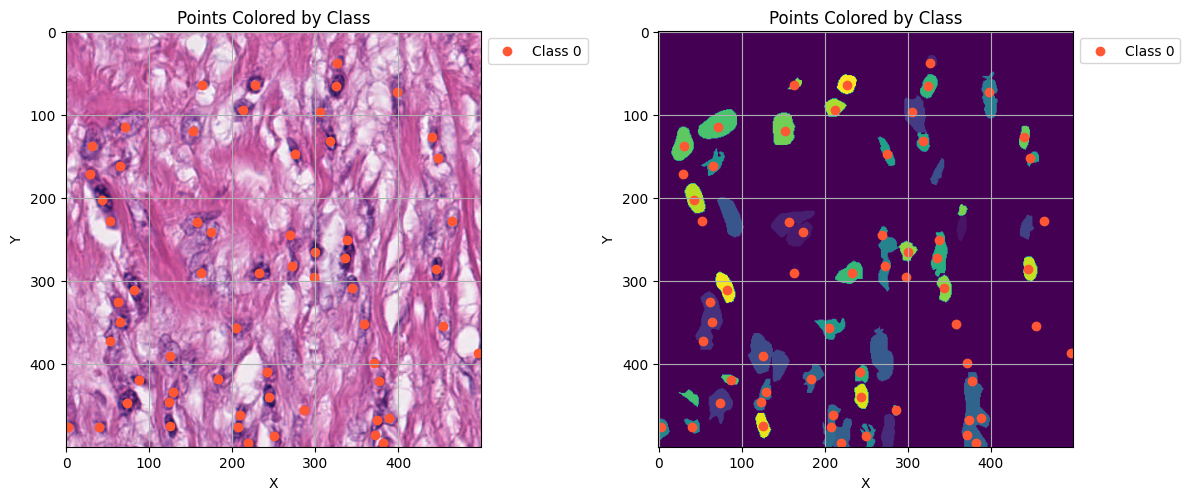

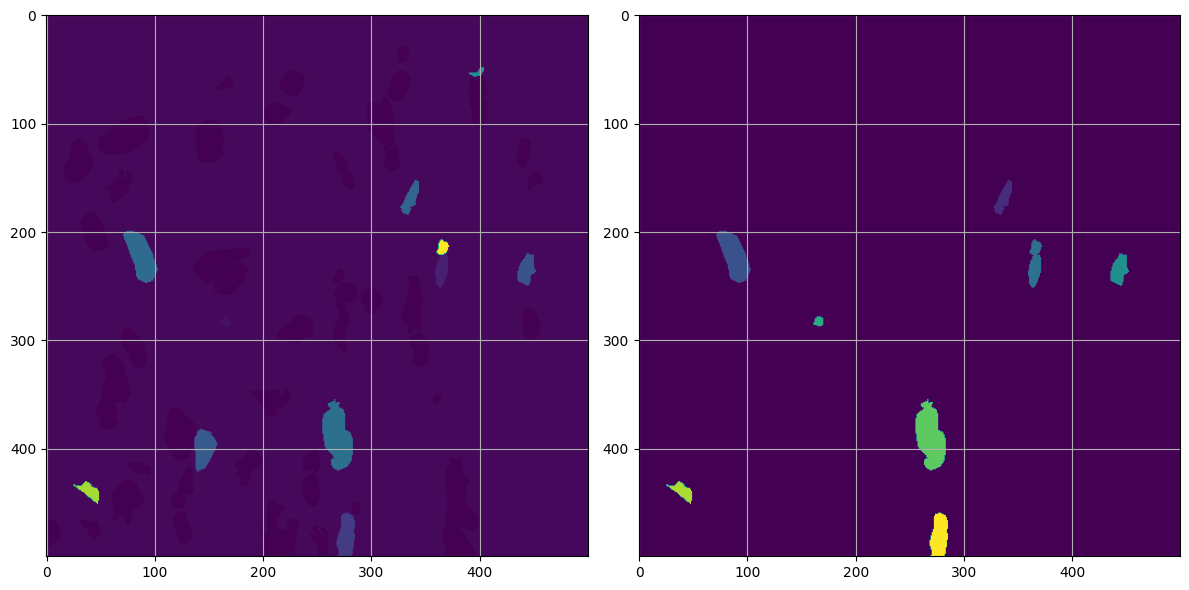

In [86]:
dataset = 'cpm17'
file_name = 'image_17'
file_path = '/data/hotaru/projects/PNS_tmp/segmentor/prompts/cpm17_300/'
inst_map,type_map,points,points_labels = load_dataset(dataset, file_name,file_path)
false_points,temp_inst_map, semantic_liantong_map= count_false_points(inst_map,type_map,points,points_labels)

# 打开PNG图像
image_path = "/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Images/"+file_name+".png"
image = Image.open(image_path)
# 创建绘图对象和子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
for label in np.unique(points_labels):
    idx = points_labels == label
    axes[0].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_title("Points Colored by Class")
axes[0].grid(True)

# 在第二个子图中绘制mask和点
axes[1].imshow(inst_map)
for label in np.unique(points_labels):
    idx = points_labels == label
    axes[1].scatter(points[idx, 0], points[idx, 1], label=f"Class {int(label)}", c=[colors[int(label)]], cmap=cmap)
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_title("Points Colored by Class")
axes[1].grid(True)

# 在每个子图的外部显示图例
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(temp_inst_map)
axes[0].grid(True)

axes[1].imshow(semantic_liantong_map )
axes[1].grid(True)
plt.tight_layout()
plt.show()


# 统计数据集粘连or单独实例个数脚本

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.io import loadmat
import cv2
from skimage.measure import label

# 生成固定的数字-颜色映射
colors = ['#FF5733',  '#ADD8E6', '#FFD700','#800080', '#FFFFFF',]
colors_mask = ['#FFFFFF', '#FF1F00',  '#4080FF', '#FFFF00','#2D0040', '#999999']
 # 用于绘制 mask 图，颜色保持一致
cmap = ListedColormap(colors)
cmap_mask = ListedColormap(colors_mask)

#return inst_map,type_map,points,points_labels
def load_map(dataset,file_name):
    if dataset == 'pannuke':
        # point_data = np.load(file_path+"/"+file_name+".npy")
        mask_data = np.load("/data/hotaru/projects/PNS_tmp/segmentor/datasets/pannuke/Masks/"+file_name+".npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = mask_data['type_map']
    elif dataset == 'cpm17':
        mask_data = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/"+file_name+".mat")  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = np.ones_like(inst_map)
    else:
        print("暂不支持其他数据集")
        return

    return inst_map,type_map

def count_pixels_per_instance(inst_map):
    unique_insts, counts = np.unique(inst_map, return_counts=True)
    inst_counts = dict(zip(unique_insts, counts))
    return inst_counts
#return [num_gt_instances,num_points,true_counts,m_back_count,m_front_count,l_single_count,l_multi_count,cls_false_count,all_false_num],temp_inst_map,semantic_liantong_map
def count_single_or_multi(inst_map):
    #初始化所需变量
    temp_inst_map = inst_map.copy()
    temp_inst_map = temp_inst_map.astype(np.int8)    #实例图数目
    binary_num , binary_semantic_map = cv2.connectedComponents(temp_inst_map,connectivity=8)   #二值图数目  
    # binary_semantic_map = label(temp_inst_map, connectivity=1)  # 连通区域标记
    binary_result_map = np.zeros_like(temp_inst_map, dtype=np.uint16)

    
    save_counted_map = np.zeros_like(temp_inst_map)
    save_012_map = np.zeros_like(temp_inst_map) #我要保存当前inst是单独inst还是粘连inst

    num_gt_instances = 0 # 0. 实例总数
    single_inst = 0      # 1. 单个实例数
    multi_inst = 0       # 2. 粘连实例数

    num_gt_instances = len(np.unique(inst_map)) - 1  # 0. 减去背景标签
    # print(np.unique(inst_map))

    # 遍历二值图的连通域，跟inst连通图去做乘(分别构造成1 0 的二值图) 看乘出来结果的unique数目
    binary_semantic_map = binary_semantic_map.astype(np.int16)
    # print(np.unique(binary_semantic_map))
    binary_num = np.max(binary_semantic_map)  # 获取连通区域数目
    current_unique_count = []
    current_region_save = []
    for i in range(1, binary_num + 1):
        # 将当前连通区域标记为1，其余区域标记为0
        current_region = np.where(binary_semantic_map == i, 1, 0)  #不会晒出来背景。
                
        current_region_save.append(current_region)
        current_unique = len(np.unique(current_region * temp_inst_map))-1
        if current_unique == 1:
            single_inst += 1
            #在012map保存单独inst
            save_012_map += current_region
        else:
            multi_inst += current_unique
            #在012map保存粘连inst
            save_012_map += (current_region*2)
        # 把当前的图加上初始化图保存下来
        save_counted_map += current_region
 
        current_unique_count.append(current_unique)

    # 计算数到的二值图和gt二值图的差异
    differ_map = binary_result_map - save_counted_map
    print("0. gt总数",num_gt_instances)
    print("1. 单个实例数",single_inst)
    print("2. 粘连实例数",multi_inst)

    return [num_gt_instances,single_inst,multi_inst,temp_inst_map,binary_semantic_map,current_region_save,save_counted_map,differ_map],save_012_map


0. gt总数 77
1. 单个实例数 61
2. 粘连实例数 16
[0 1 2]


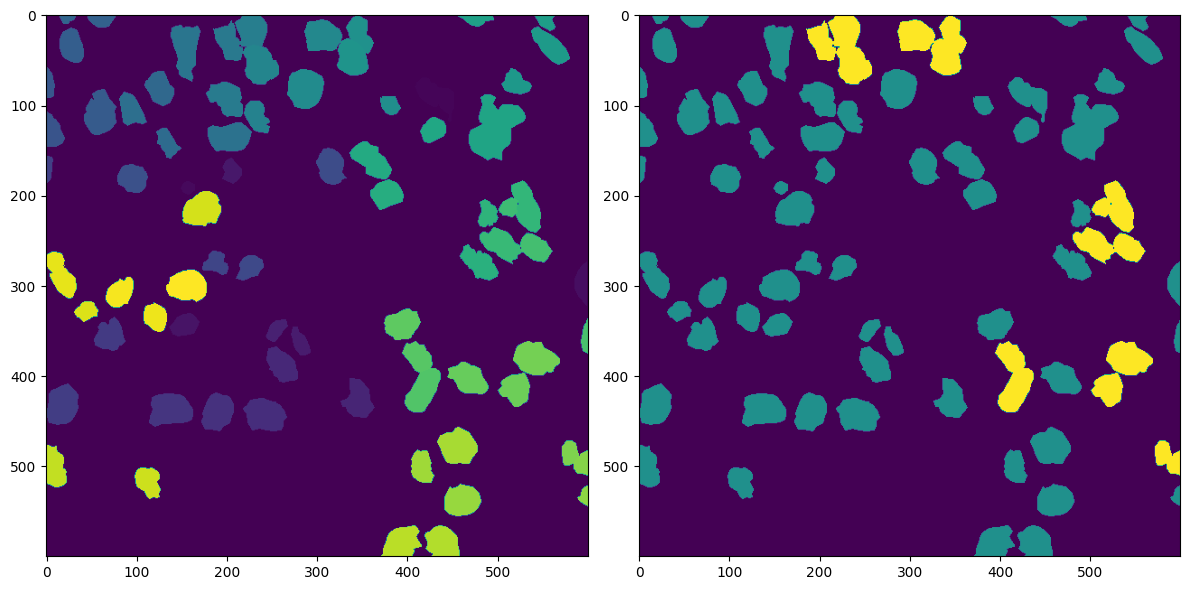

In [119]:
file_name = 'image_00'
inst_map,type_map = load_map('cpm17',file_name)
[num_gt_instances,single_inst,multi_inst,temp_inst_map,binary_semantic_map,current_region_save,save_counted_map,differ_map],save_012_map = count_single_or_multi(inst_map)
print(np.unique(save_012_map))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(inst_map)
axes[1].imshow(save_012_map)
# axes[2].imshow(save_012_map )
# axes[2].imshow(current_region_save[0] )
# axes[2].grid(True)
plt.tight_layout()
plt.show()


# import os
# import csv
# '''
# 循环计数所有的数据集，首先看有多少粘连有多少单个实例。保存csv
# '''
# def process_dataset(dataset_folder,dataset):
#     csv_data = []  # 用于存储CSV数据的列表

#     for file_name in os.listdir(dataset_folder):
#         if file_name.endswith('.mat'):  # 假设数据集文件都是.txt格式的
#             file_path = os.path.join(dataset_folder, file_name)
#             file_name = file_name.split(".")[0]
#             print(file_name)
#             inst_map, type_map = load_map(dataset, file_name)
#             num_gt_instances,single_inst,multi_inst,temp_inst_map,binary_semantic_map,current_region_save,save_counted_map,differ_map = count_single_or_multi(inst_map)
            
#             # 将数据添加到CSV数据列表中
#             csv_data.append([file_name, num_gt_instances, single_inst, multi_inst])
    
#     # 定义CSV文件路径
#     csv_file_path = "/data/hotaru/projects/PNS_tmp/segmentor/outputAndOtherfile/count_CPM17_multi_or_single_2.csv"

#     # 写入CSV文件
#     with open(csv_file_path, 'w', newline='') as csvfile:
#         csv_writer = csv.writer(csvfile)
#         # 写入表头
#         csv_writer.writerow(['File Name', 'Num GT Instances', 'Single Instance', 'Multi Instance'])
#         # 写入数据
#         csv_writer.writerows(csv_data)

#     print("CSV文件已保存到:", csv_file_path)

# # 调用函数处理数据集文件夹
# dataset_folder = "/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/"
# # dataset_folder = '/data/hotaru/projects/PNS_tmp/segmentor/datasets/pannuke/Masks/'
# dataset = 'cpm17'
# process_dataset(dataset_folder,dataset)



# 把点划分为粘连实例点与单独实例点

In [124]:
# 肯定是要遍历所有点的 先读一下
import numpy as np
from scipy.io import loadmat

#return inst_map,type_map,points,points_labels
def load_dataset(dataset,file_name,point_path):
    if dataset == 'pannuke':
        point_data = np.load(point_path+"/"+file_name+".npy")
        mask_data = np.load("/data/hotaru/projects/PNS_tmp/segmentor/datasets/pannuke/Masks/"+file_name+".npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = mask_data['type_map']
    elif dataset == 'cpm17':
        point_data = np.load(point_path+"/"+file_name+".npy")
        mask_data = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/"+file_name+".mat")  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = np.ones_like(inst_map)
    else:
        print("暂不支持其他数据集")
        return
    # 提取坐标和类别信息
    points = point_data[:, :2]
    points_labels = point_data[:, 2]
    return inst_map,type_map,points,points_labels


point_path = '/data/hotaru/projects/PNS_tmp/segmentor/prompts/cpm17_gt'
dataset = 'cpm17'
# dataset_folder = file_path
for file_name in os.listdir(point_path):
    if file_name.endswith('.npy'):  # 假设数据集文件都是.txt格式的
        file_path = os.path.join(point_path, file_name)
        file_name = file_name.split(".")[0]
        print(file_name)
        inst_map,type_map,points,points_labels = load_dataset(dataset,file_name,point_path)
        meiyong = []
        meiyong,save_012_map = count_single_or_multi(inst_map)
        single_points = []
        multi_points = []
        for x,y in points:
            # print(int(x),int(y))
            x = int(x);y=int(y)
            if save_012_map[y][x]==1:
                single_points.append([x,y])
            if save_012_map[y][x]==2:
                multi_points.append([x,y])
        #保存
                # 定义保存路径和文件名
        save_dir = '/data/hotaru/projects/PNS_tmp/segmentor/prompts/cpm'
        save_filename = file_name+'.npy'
        if len(multi_points)==0:
            multi_points.append([0,0])
        # 检查目标文件夹是否存在，如果不存在则创建
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # 将数组保存为npy文件
        multi_save_path = os.path.join(save_dir+'_multi', save_filename)
        np.save(multi_save_path, multi_points)

        single_save_path = os.path.join(save_dir+'_single', save_filename)
        np.save(single_save_path, single_points)

    # break



image_01
0. gt总数 173
1. 单个实例数 159
2. 粘连实例数 14
image_00
0. gt总数 77
1. 单个实例数 61
2. 粘连实例数 16
image_03
0. gt总数 232
1. 单个实例数 178
2. 粘连实例数 54
image_04
0. gt总数 115
1. 单个实例数 63
2. 粘连实例数 52
image_06
0. gt总数 169
1. 单个实例数 81
2. 粘连实例数 88
image_02
0. gt总数 135
1. 单个实例数 118
2. 粘连实例数 17
image_07
0. gt总数 143
1. 单个实例数 68
2. 粘连实例数 75
image_08
0. gt总数 177
1. 单个实例数 160
2. 粘连实例数 17
image_05
0. gt总数 40
1. 单个实例数 38
2. 粘连实例数 2
image_09
0. gt总数 153
1. 单个实例数 95
2. 粘连实例数 58
image_10
0. gt总数 31
1. 单个实例数 27
2. 粘连实例数 4
image_13
0. gt总数 67
1. 单个实例数 45
2. 粘连实例数 22
image_12
0. gt总数 175
1. 单个实例数 74
2. 粘连实例数 101
image_11
0. gt总数 72
1. 单个实例数 66
2. 粘连实例数 6
image_14
0. gt总数 123
1. 单个实例数 59
2. 粘连实例数 64
image_16
0. gt总数 68
1. 单个实例数 57
2. 粘连实例数 11
image_15
0. gt总数 135
1. 单个实例数 86
2. 粘连实例数 49
image_17
0. gt总数 56
1. 单个实例数 40
2. 粘连实例数 16
image_18
0. gt总数 108
1. 单个实例数 49
2. 粘连实例数 59
image_19
0. gt总数 203
1. 单个实例数 165
2. 粘连实例数 38
image_21
0. gt总数 61
1. 单个实例数 61
2. 粘连实例数 0
image_20
0. gt总数 180
1. 单个实例数 140
2. 粘连实例数 40
image_22
0. gt总

0. gt总数 173
1. 单个实例数 159
2. 粘连实例数 14


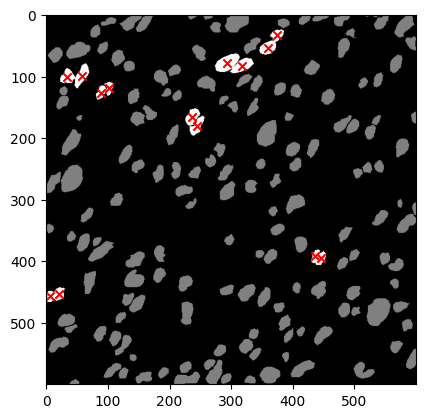

In [122]:
# 检查一下保存的multi点


import numpy as np
import matplotlib.pyplot as plt

# 读取点数据
points = np.load('/data/hotaru/projects/PNS_tmp/segmentor/prompts/cpm_multi/image_01.npy')
mask_data = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/image_01.mat")  # 加载npy文件并将字典转换为Python对象
inst_map = mask_data['inst_map']
meiyong = []
meiyong,save_012_map = count_single_or_multi(inst_map)
# 读取地图数据
map_data = save_012_map

# 创建一个图形对象
plt.figure()

# 绘制地图数据
plt.imshow(map_data, cmap='gray')

# 绘制点数据
plt.scatter(points[:, 0], points[:, 1], c='red', marker='x')

# 显示图形
plt.show()


# 把mask划分为粘连gt和单独gt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.io import loadmat
import cv2
from skimage.measure import label

# 生成固定的数字-颜色映射
colors = ['#FF5733',  '#ADD8E6', '#FFD700','#800080', '#FFFFFF',]
colors_mask = ['#FFFFFF', '#FF1F00',  '#4080FF', '#FFFF00','#2D0040', '#999999']
 # 用于绘制 mask 图，颜色保持一致
cmap = ListedColormap(colors)
cmap_mask = ListedColormap(colors_mask)

#return inst_map,type_map,points,points_labels
def load_map(dataset,file_name):
    if dataset == 'pannuke':
        # point_data = np.load(file_path+"/"+file_name+".npy")
        mask_data = np.load("/data/hotaru/projects/PNS_tmp/segmentor/datasets/pannuke/Masks/"+file_name+".npy", allow_pickle=True).item()  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = mask_data['type_map']
    elif dataset == 'cpm17':
        mask_data = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/"+file_name+".mat")  # 加载npy文件并将字典转换为Python对象
        inst_map = mask_data['inst_map']
        type_map = np.ones_like(inst_map)
    else:
        print("暂不支持其他数据集")
        return

    return inst_map,type_map

def count_single_or_multi(inst_map):
    #初始化所需变量
    temp_inst_map = inst_map.copy()
    temp_inst_map = temp_inst_map.astype(np.int8)    #实例图数目
    binary_num , binary_semantic_map = cv2.connectedComponents(temp_inst_map,connectivity=8)   #二值图数目  
    # binary_semantic_map = label(temp_inst_map, connectivity=1)  # 连通区域标记
    binary_result_map = np.zeros_like(temp_inst_map, dtype=np.uint16)

    
    save_counted_map = np.zeros_like(temp_inst_map)
    save_012_map = np.zeros_like(temp_inst_map) #我要保存当前inst是单独inst还是粘连inst

    num_gt_instances = 0 # 0. 实例总数
    single_inst = 0      # 1. 单个实例数
    multi_inst = 0       # 2. 粘连实例数

    num_gt_instances = len(np.unique(inst_map)) - 1  # 0. 减去背景标签
    # print(np.unique(inst_map))

    # 遍历二值图的连通域，跟inst连通图去做乘(分别构造成1 0 的二值图) 看乘出来结果的unique数目
    binary_semantic_map = binary_semantic_map.astype(np.int16)
    # print(np.unique(binary_semantic_map))
    binary_num = np.max(binary_semantic_map)  # 获取连通区域数目
    current_unique_count = []
    current_region_save = []

    save_single_map = np.zeros_like(temp_inst_map)
    save_multi_map = np.zeros_like(temp_inst_map)
    for i in range(1, binary_num + 1):
        # 将当前连通区域标记为1，其余区域标记为0
        current_region = np.where(binary_semantic_map == i, 1, 0)  #不会晒出来背景。
                
        current_region_save.append(current_region)
        current_map = current_region * temp_inst_map
        current_unique = len(np.unique(current_map))-1
        if current_unique == 1:
            single_inst += 1
            #在012map保存单独inst
            save_012_map += current_region
            save_single_map += current_map
        else:
            multi_inst += current_unique
            #在012map保存粘连inst
            save_012_map += (current_region*2)
            save_multi_map += current_map
        # 把当前的图加上初始化图保存下来
        save_counted_map += current_region
 
        current_unique_count.append(current_unique)

    # 计算数到的二值图和gt二值图的差异
    differ_map = binary_result_map - save_counted_map
    print("0. gt总数",num_gt_instances)
    print("1. 单个实例数",single_inst)
    print("2. 粘连实例数",multi_inst)

    return [num_gt_instances,single_inst,multi_inst,temp_inst_map,binary_semantic_map,current_region_save,save_counted_map,differ_map],save_012_map,save_single_map,save_multi_map


In [17]:
# 检查一下保存的multi点


# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import scipy.io
# mask_data = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels_all/image_07.mat")  # 加载npy文件并将字典转换为Python对象
# # save_single_map = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels/image_07.mat")['inst_map']
# # save_multi_map = loadmat("/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels_single/image_07.mat")['inst_map']
# inst_map = mask_data['inst_map']
# # meiyong = []
# meiyong,save_012_map,save_single_map , save_multi_map = count_single_or_multi(inst_map)
# # # 读取地图数据
# # map_data = save_012_map

# fig, axes = plt.subplots(1, 3, figsize=(12, 6))
# axes[0].imshow(inst_map)
# axes[1].imshow(save_single_map)
# axes[2].imshow(save_multi_map)

# plt.tight_layout()
# plt.show()

lables_path = '/data/hotaru/projects/PNS_tmp/segmentor/datasets/cpm17/test/Labels_all'
multi_save_path = lables_path+'_multi/'
os.makedirs(multi_save_path,exist_ok=True)

single_save_path = lables_path+'_single/'
os.makedirs(single_save_path,exist_ok=True)
for file_name in os.listdir(lables_path):
    if file_name.endswith('.mat'):  
        file_path = os.path.join(lables_path, file_name)
        file_name = file_name.split(".")[0]
        print(file_name)
        mask_data = loadmat(file_path)
        inst_map = mask_data['inst_map']

        multi_map = mask_data.copy()
        single_map = mask_data.copy()

        meiyong = []
        meiyong,save_012_map,save_single_map , save_multi_map = count_single_or_multi(inst_map)
        multi_map['inst_map'] = save_multi_map
        single_map['inst_map'] = save_single_map
       
        scipy.io.savemat(multi_save_path+file_name+'.mat' , multi_map)
        scipy.io.savemat(single_save_path+file_name+'.mat' , single_map)


image_00


0. gt总数 77
1. 单个实例数 61
2. 粘连实例数 16
image_01
0. gt总数 173
1. 单个实例数 159
2. 粘连实例数 14
image_02
0. gt总数 135
1. 单个实例数 118
2. 粘连实例数 17
image_03
0. gt总数 232
1. 单个实例数 178
2. 粘连实例数 54
image_04
0. gt总数 115
1. 单个实例数 63
2. 粘连实例数 52
image_05
0. gt总数 40
1. 单个实例数 38
2. 粘连实例数 2
image_06
0. gt总数 169
1. 单个实例数 81
2. 粘连实例数 88
image_07
0. gt总数 143
1. 单个实例数 68
2. 粘连实例数 75
image_08
0. gt总数 177
1. 单个实例数 160
2. 粘连实例数 17
image_09
0. gt总数 153
1. 单个实例数 95
2. 粘连实例数 58
image_10
0. gt总数 31
1. 单个实例数 27
2. 粘连实例数 4
image_11
0. gt总数 72
1. 单个实例数 66
2. 粘连实例数 6
image_12
0. gt总数 175
1. 单个实例数 74
2. 粘连实例数 101
image_13
0. gt总数 67
1. 单个实例数 45
2. 粘连实例数 22
image_14
0. gt总数 123
1. 单个实例数 59
2. 粘连实例数 64
image_15
0. gt总数 135
1. 单个实例数 86
2. 粘连实例数 49
image_16
0. gt总数 68
1. 单个实例数 57
2. 粘连实例数 11
image_17
0. gt总数 56
1. 单个实例数 40
2. 粘连实例数 16
image_18
0. gt总数 108
1. 单个实例数 49
2. 粘连实例数 59
image_19
0. gt总数 203
1. 单个实例数 165
2. 粘连实例数 38
image_20
0. gt总数 180
1. 单个实例数 140
2. 粘连实例数 40
image_21
0. gt总数 61
1. 单个实例数 61
2. 粘连实例数 0
image_22
0. gt总数 95
1. 单